In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

2025-08-06 00:36:50.865953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754440611.130943      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754440611.208997      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Preparation

In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_label = train["label"]
train_pixels = train.drop(labels=["label"], axis=1)

# Free some space
del train

print(f"train_pixels => {train_pixels.shape}")
print(f"train_label => {train_label.shape}")
print(f"test => {test.shape}")

train_pixels => (42000, 784)
train_label => (42000,)
test => (28000, 784)


## Exploration

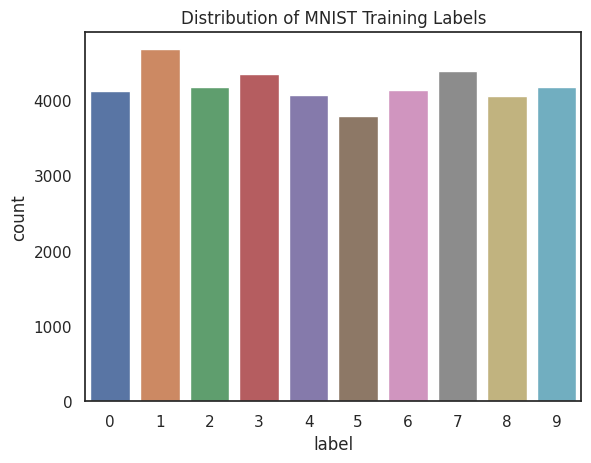

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [4]:
sns.set(style='white', context='notebook', palette='deep')
g = sns.countplot(x=train_label)
plt.title("Distribution of MNIST Training Labels")
plt.show()

train_label.value_counts()

We have similar counts for the 10 digits.

### Normalize and Reshape the Data

In [5]:
# Normalization
train_pixels = train_pixels / 255.0
test = test / 255.0

# Reshape
train_pixels = train_pixels.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)
print(f"train_pixels => {train_pixels.shape}")
print(f"test => {test.shape}")

train_pixels => (42000, 28, 28, 1)
test => (28000, 28, 28, 1)


### Visualization

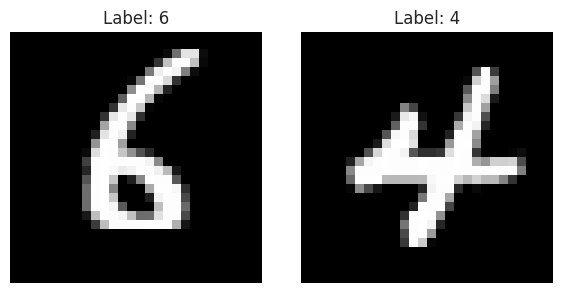

In [6]:
# Some examples
plt.figure(figsize=(6, 3))  # Create a figure with appropriate size

# First digit
plt.subplot(1, 2, 1)
plt.imshow(train_pixels[45][:, :, 0], cmap="gray")
plt.title(f"Label: {train_label[45]}")
plt.axis('off')  # Turn off axis for cleaner display

# Second digit
plt.subplot(1, 2, 2)
plt.imshow(train_pixels[81][:, :, 0], cmap="gray")
plt.title(f"Label: {train_label[81]}")
plt.axis('off')

plt.tight_layout()
plt.show()

### Label Encoding

In [7]:
train_label_cat = to_categorical(train_label, num_classes=10)

### Train, Dev, Test sets Distribution

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train_pixels, train_label_cat, test_size=0.1, random_state=42)
print(X_valid.shape)

(4200, 28, 28, 1)


## CNN - Define the Model

In [9]:
model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28,28,1)),
    Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(units=256, activation="relu"),
    Dropout(0.5),
    Dense(units=10, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754440630.305502      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,530 (3.39 MB)

 Trainable params: 887,530 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
history = model.fit(X_train, y_train, batch_size=86, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2


I0000 00:00:1754440634.020600      59 service.cc:148] XLA service 0x7a47cc00cbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754440634.021270      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754440634.303835      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


 33/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4192 - loss: 1.6661

I0000 00:00:1754440637.577508      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8435 - loss: 0.4699 - val_accuracy: 0.9724 - val_loss: 0.0878
Epoch 2/2
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9783 - loss: 0.0711 - val_accuracy: 0.9886 - val_loss: 0.0350


## Data Augmentation
As, MNIST dataset is small we should use Data Augmentation as Regularization

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [14]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=86), epochs=15, validation_data=(X_valid, y_valid), steps_per_epoch=X_train.shape[0] // 86, callbacks=[learning_rate_reduction])

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9481 - loss: 0.1706 - val_accuracy: 0.9886 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 2/15
  1/439 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9884 - loss: 0.0294

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.9884 - loss: 0.0294 - val_accuracy: 0.9902 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9734 - loss: 0.0879 - val_accuracy: 0.9871 - val_loss: 0.0448 - learning_rate: 0.0010
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.9767 - loss: 0.1856 - val_accuracy: 0.9893 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9781 - loss: 0.0722 - val_accuracy: 0.9888 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.9419 - loss: 0.2084 - val_accuracy: 0.9862 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9814 - loss: 0.0634 - val_accuracy: 0.9900 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.9884 - loss: 0.0932

### Training and Evaluation

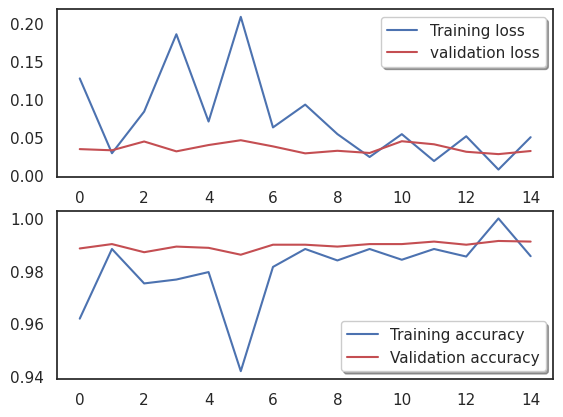

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Explore the Errors

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


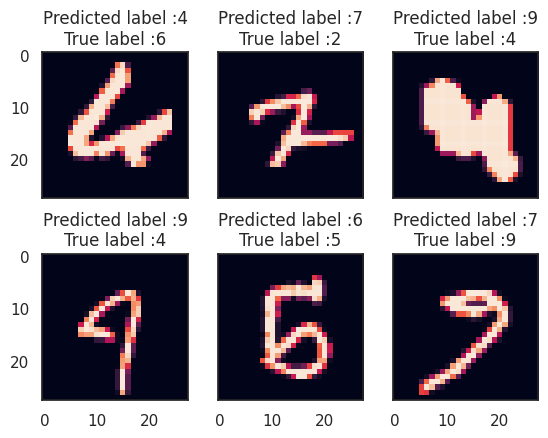

In [16]:
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid,axis = 1)

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### Final Submission

In [17]:
results = model.predict(test)
results = np.argmax(results, axis=1)

results = pd.Series(results, name="Label")

aak_submission = pd.concat([pd.Series(range(1, (test.shape[0]+1)),name = "ImageId"), results],axis = 1)

aak_submission.to_csv("aak_cnn_mnist_datagen.csv",index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
